# Using shared variables (`Data` container adaptation)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## The Data class

The [Data](../api/data.rst) container class wraps the theano shared variable class and lets the model be aware of its inputs and outputs. This allows one to change the value of an observed variable to predict or refit on new data. All variables of this class must be declared inside a model context and specify a name for them.

In the following example, this is demonstrated with fictional temperature observations.

In [3]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-05-20")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = np.random.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

,Berlin,San Marino,Paris
date,,,
2020-05-01,14.708568,18.905539,15.230894
2020-05-02,13.729669,17.359776,16.461333
2020-05-03,15.919799,17.766166,15.369512
2020-05-04,17.294473,17.685680,14.724499
2020-05-05,14.661021,18.648179,17.882056


PyMC3 can also keep track of the dimensions (like dates or cities) and coordinates (such as the actual date times or city names) of multi-dimensional data. That way, when wraping your data around the `Data` container when building your model, you can specify the dimension names and coordinates of random variables, instead of specifying the shapes of those random variables as numbers.

More generally, there are two ways to specify new dimensions and their coordinates:
- Entering the dimensions in the `dims` kwarg of a `pm.Data` variable with a pandas Series or DataFrame. The name of the index and columns will be remembered as the dimensions, and PyMC3 will infer that the values of the given columns must be the coordinates.
- Using the new `coords` argument to `pm.Model` to set the coordinates explicitly.

For more explanation about dimensions, coordinates and their big benefits, we encourage you to take a look at the [ArviZ quickstart](https://arviz-devs.github.io/arviz/notebooks/Introduction.html#Convert-to-InferenceData).

This is a lot of explanation -- let's see how it's done! We will use a hierarchical model: it assumes a mean temperature for the European continent and models each city relative to the continent mean:

In [4]:
# The data has two dimensions: date and city
coords = {"date": df_data.index, "city": df_data.columns}

In [5]:
with pm.Model(coords=coords) as model:
    europe_mean = pm.Normal("europe_mean_temp", mu=15.0, sigma=3.0)
    city_offset = pm.Normal("city_offset", mu=0.0, sigma=3.0, dims="city")
    city_temperature = pm.Deterministic("city_temperature", europe_mean + city_offset, dims="city")

    data = pm.Data("data", df_data, dims=("date", "city"))
    _ = pm.Normal("likelihood", mu=city_temperature, sigma=0.5, observed=data)

    idata = pm.sample(
        2000,
        tune=2000,
        target_accept=0.85,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [city_offset, europe_mean_temp]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The number of effective samples is smaller than 10% for some parameters.


And we see that the model did remember the coords we gave it:

In [6]:
model.coords

{'date': DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
                '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
                '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
                '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
                '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20'],
               dtype='datetime64[ns]', name='date', freq='D'),
 'city': Index(['Berlin', 'San Marino', 'Paris'], dtype='object')}

Since [ArviZ PR #1228](https://github.com/arviz-devs/arviz/pull/1228), the coordinates are automatically stored into the `InferenceData` object:

In [7]:
idata.posterior.coords

Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * city     (city) object 'Berlin' 'San Marino' 'Paris'

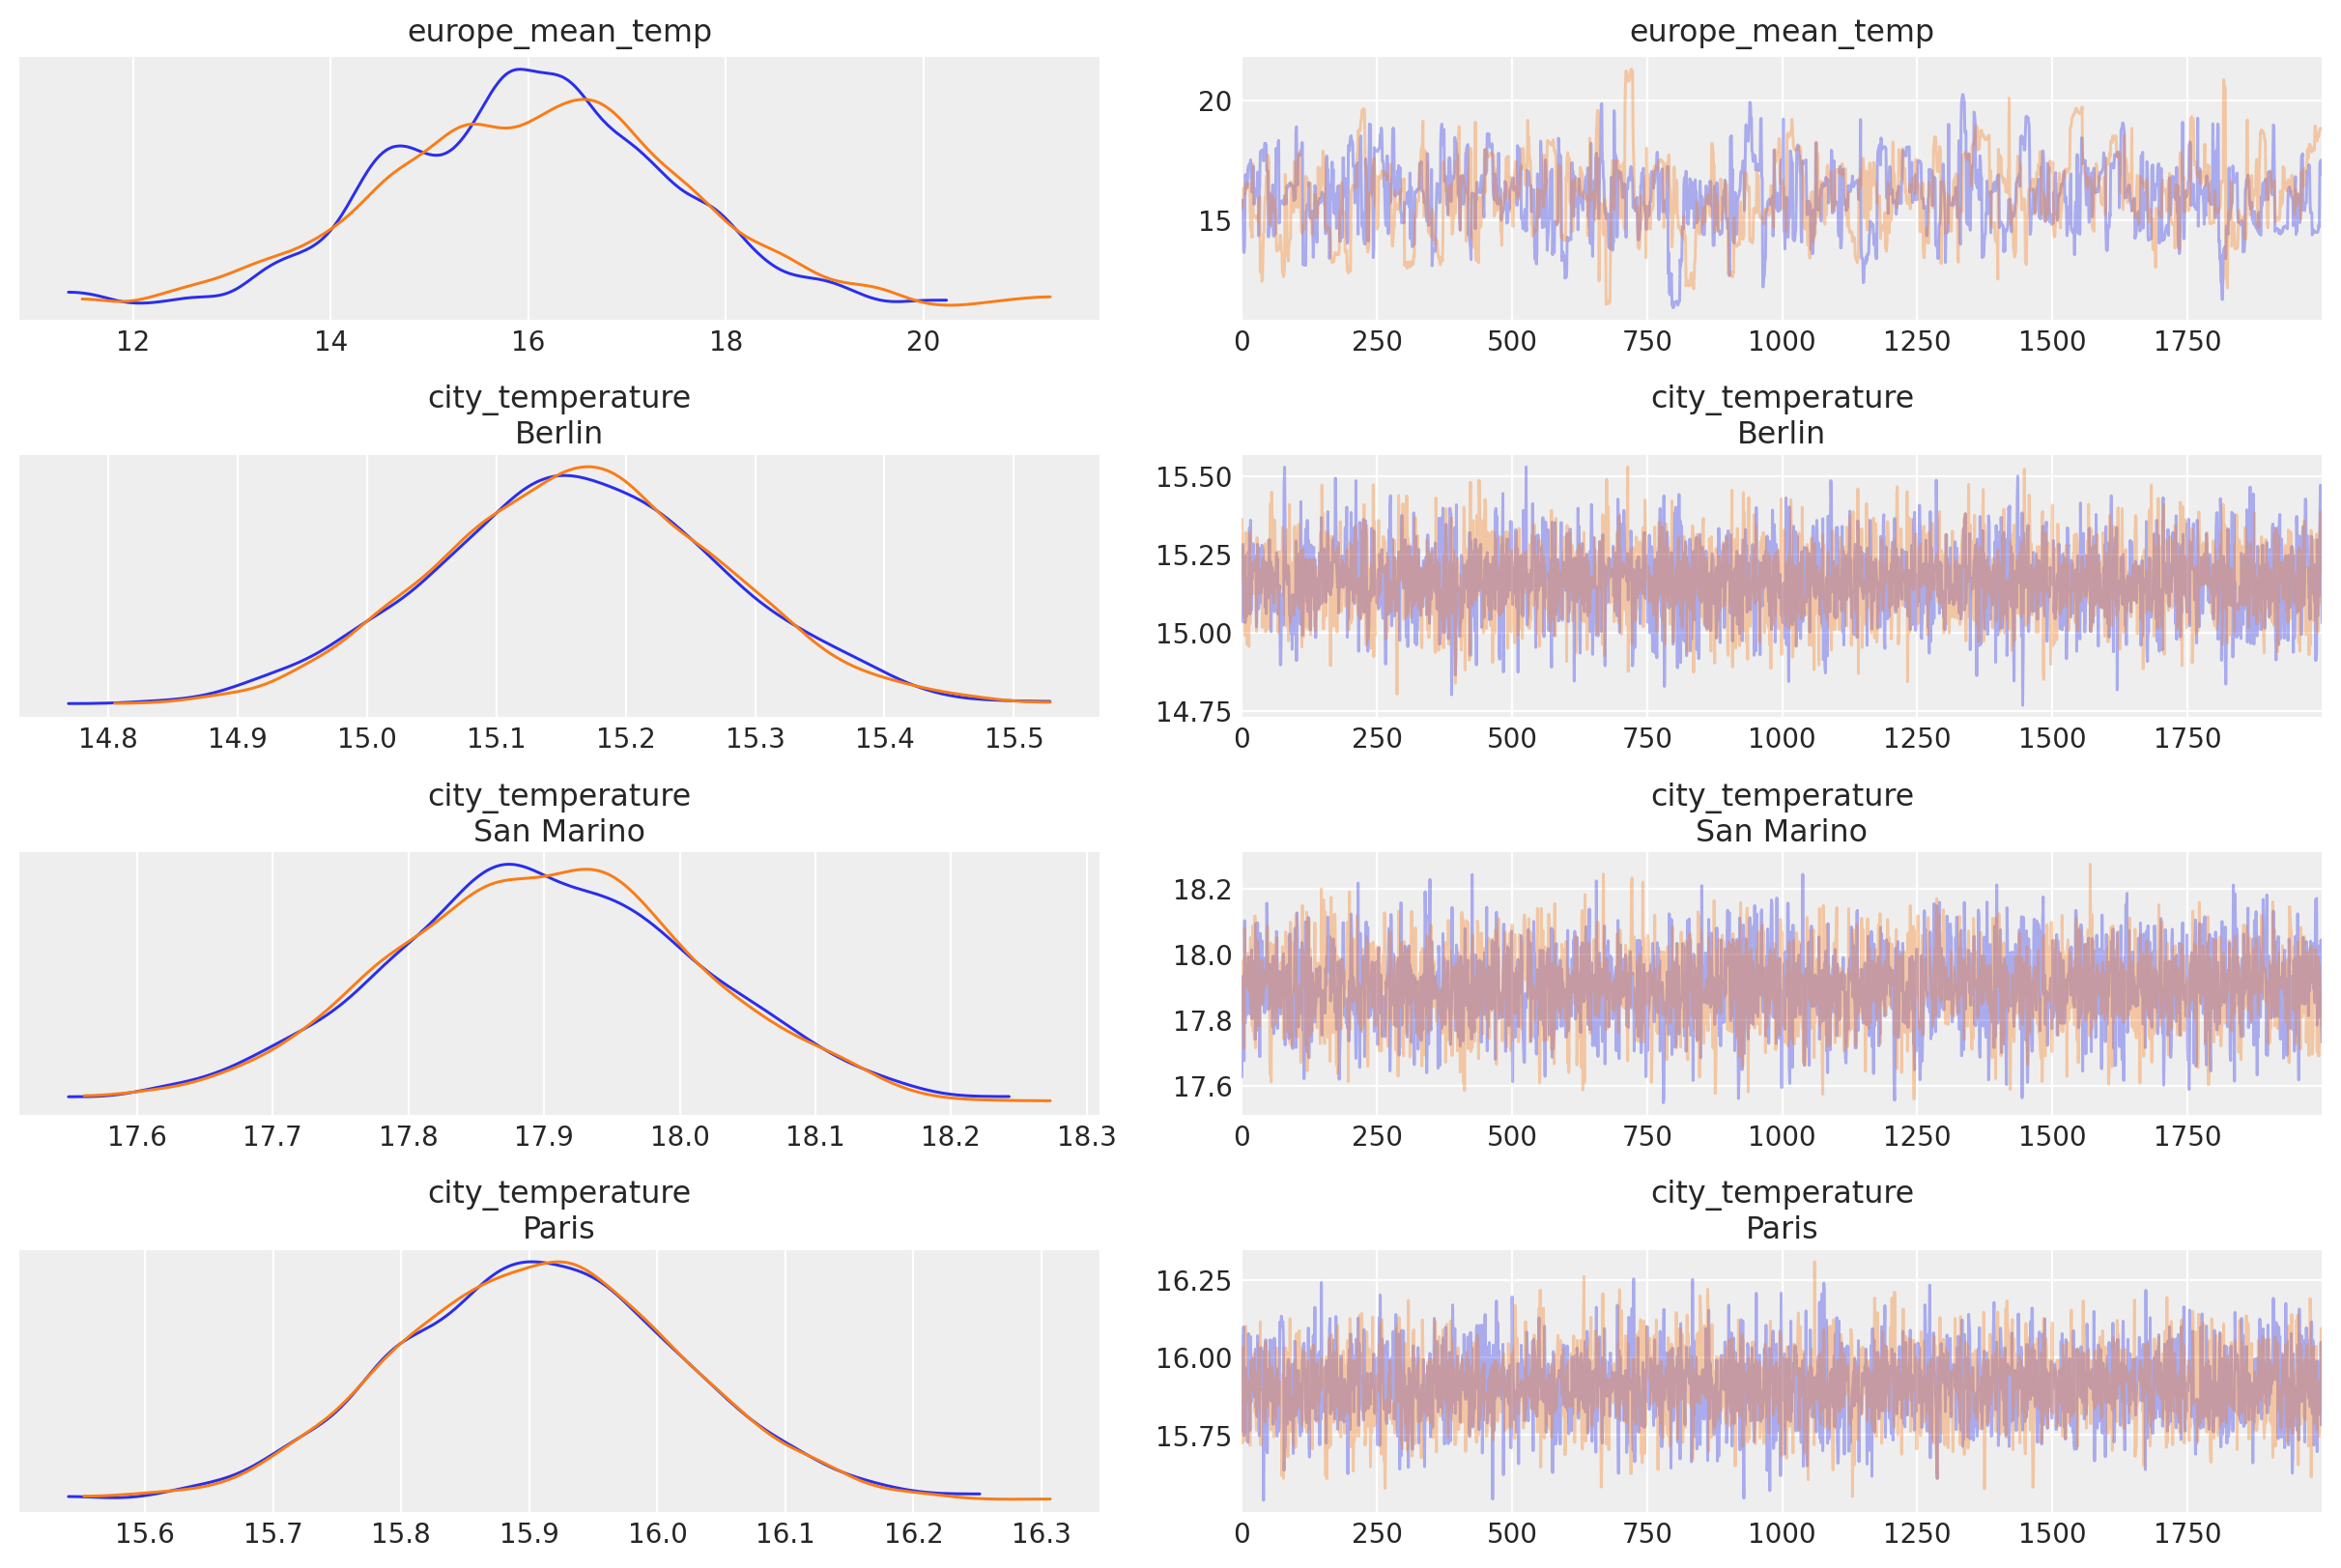

In [8]:
az.plot_trace(idata, var_names=["europe_mean_temp", "city_temperature"]);

We can get the data container variable from the model using:

In [9]:
model["data"].get_value()

array([[14.70856787, 18.90553869, 15.23089386],
       [13.72966919, 17.3597762 , 16.46133259],
       [15.91979879, 17.76616615, 15.36951161],
       [17.29447325, 17.6856797 , 14.72449876],
       [14.661021  , 18.6481792 , 17.88205622],
       [13.62235193, 18.1174869 , 17.93472161],
       [17.17794384, 18.40834446, 13.95283813],
       [12.86745876, 17.71733043, 15.54609181],
       [15.45146367, 17.37483326, 17.79029219],
       [15.1294516 , 18.6186118 , 16.27692083],
       [14.67051385, 17.52220247, 16.02126023],
       [14.6102896 , 17.81642544, 14.38041368],
       [16.96706129, 17.31780039, 15.86717085],
       [15.78099003, 18.38226964, 16.43610936],
       [15.06009008, 17.32634686, 15.39619995],
       [14.93950003, 17.6323248 , 15.2415048 ],
       [14.64521987, 18.74261167, 15.70689049],
       [15.673507  , 17.90925701, 15.72393238],
       [15.08672537, 17.85329919, 16.14461565],
       [15.20135155, 16.90967182, 16.0285069 ]])

Note that we used a [theano SharedVariable method](https://github.com/Theano/theano/blob/d395439aec5a6ddde8ef5c266fd976412a5c5695/theano/compile/sharedvalue.py#L87-L108) to get the value of the variable. This is because our variable is actually a SharedVariable.

In [10]:
type(data)

theano.tensor.sharedvar.TensorSharedVariable

We can plot the digraph for our model using:

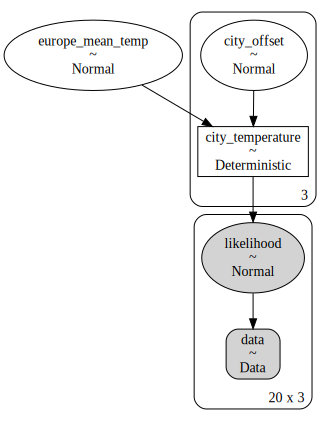

In [11]:
pm.model_to_graphviz(model)

The methods and functions related to the Data container class are:

- `data_container.get_value` (method inherited from the theano SharedVariable): gets the value associated with the `data_container`.
- `data_container.set_value` (method inherited from the theano SharedVariable): sets the value associated with the `data_container`.
- `pm.set_data`: PyMC3 function that sets the value associated with each Data container variable indicated in the dictionary `new_data` with it corresponding new value.

In [12]:
help(pm.set_data)

Help on function set_data in module pymc3.model:

set_data(new_data, model=None)
    Sets the value of one or more data container variables.
    
    Parameters
    ----------
    new_data: dict
        New values for the data containers. The keys of the dictionary are
        the variables' names in the model and the values are the objects
        with which to update.
    model: Model (optional if in `with` context)
    
    Examples
    --------
    
    .. code:: ipython
    
        >>> import pymc3 as pm
        >>> with pm.Model() as model:
        ...     x = pm.Data('x', [1., 2., 3.])
        ...     y = pm.Data('y', [1., 2., 3.])
        ...     beta = pm.Normal('beta', 0, 1)
        ...     obs = pm.Normal('obs', x * beta, 1, observed=y)
        ...     trace = pm.sample(1000, tune=1000)
    
    Set the value of `x` to predict on new data.
    
    .. code:: ipython
    
        >>> with model:
        ...     pm.set_data({'x': [5., 6., 9.]})
        ...     y_test = pm.sam

## Using Data container variables to fit the same model to several datasets

This and the next sections are an adaptation of the notebook ["Advanced usage of Theano in PyMC3"](../Advanced_usage_of_Theano_in_PyMC3.html#using-shared-variables) using `pm.Data`.

We can use `Data` container variables in PyMC3 to fit the same model to several datasets without the need to recreate the model each time (which can be time consuming if the number of datasets is large):

In [13]:
# We generate 10 datasets
true_mu = [np.random.randn() for _ in range(10)]
observed_data = [mu + np.random.randn(20) for mu in true_mu]

with pm.Model() as model:
    data = pm.Data("data", observed_data[0])
    mu = pm.Normal("mu", 0, 10)
    _ = pm.Normal("y", mu=mu, sigma=1, observed=data)

# Generate one trace for each dataset
traces = []
for data_vals in observed_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        traces.append(pm.sample(return_inferencedata=False))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


## Using Data container variables to predict on new data

We can also sometimes use `Data` container variables to work around limitations in the current PyMC3 API. A common task in machine learning is to predict values for unseen data, and one way to achieve this is to use a `Data` container variable for our observations:

In [14]:
x = np.random.randn(100)
y = x > 0

with pm.Model() as model:
    x_shared = pm.Data("x_shared", x)
    coeff = pm.Normal("x", mu=0, sigma=1)

    logistic = pm.math.sigmoid(coeff * x_shared)
    _ = pm.Bernoulli("obs", p=logistic, observed=y)

    # fit the model
    trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


In [15]:
new_values = [-1, 0, 1.0]
with model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    pm.set_data({"x_shared": new_values})
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


The same concept applied to a more complex model can be seen in the notebook [*Variational Inference: Bayesian Neural Networks*](../notebooks/bayesian_neural_network_advi.html).

## Applied example: height of toddlers as a function of age

This example is taken from Osvaldo Martin's book: [Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC3 and ArviZ, 2nd Edition](https://www.amazon.com/Bayesian-Analysis-Python-Introduction-probabilistic-ebook/dp/B07HHBCR9G).

The World Health Organization and other health institutions around the world collect data
for newborns and toddlers and design [growth charts standards](http://www.who.int/childgrowth/en/). These charts are an essential component of the paediatric toolkit and also as a measure of the general well-being of
populations in order to formulate health policies, and plan interventions and
monitor their effectiveness.

An example of such data is the lengths (heights) of newborn / toddler girls as a function of age (in months):

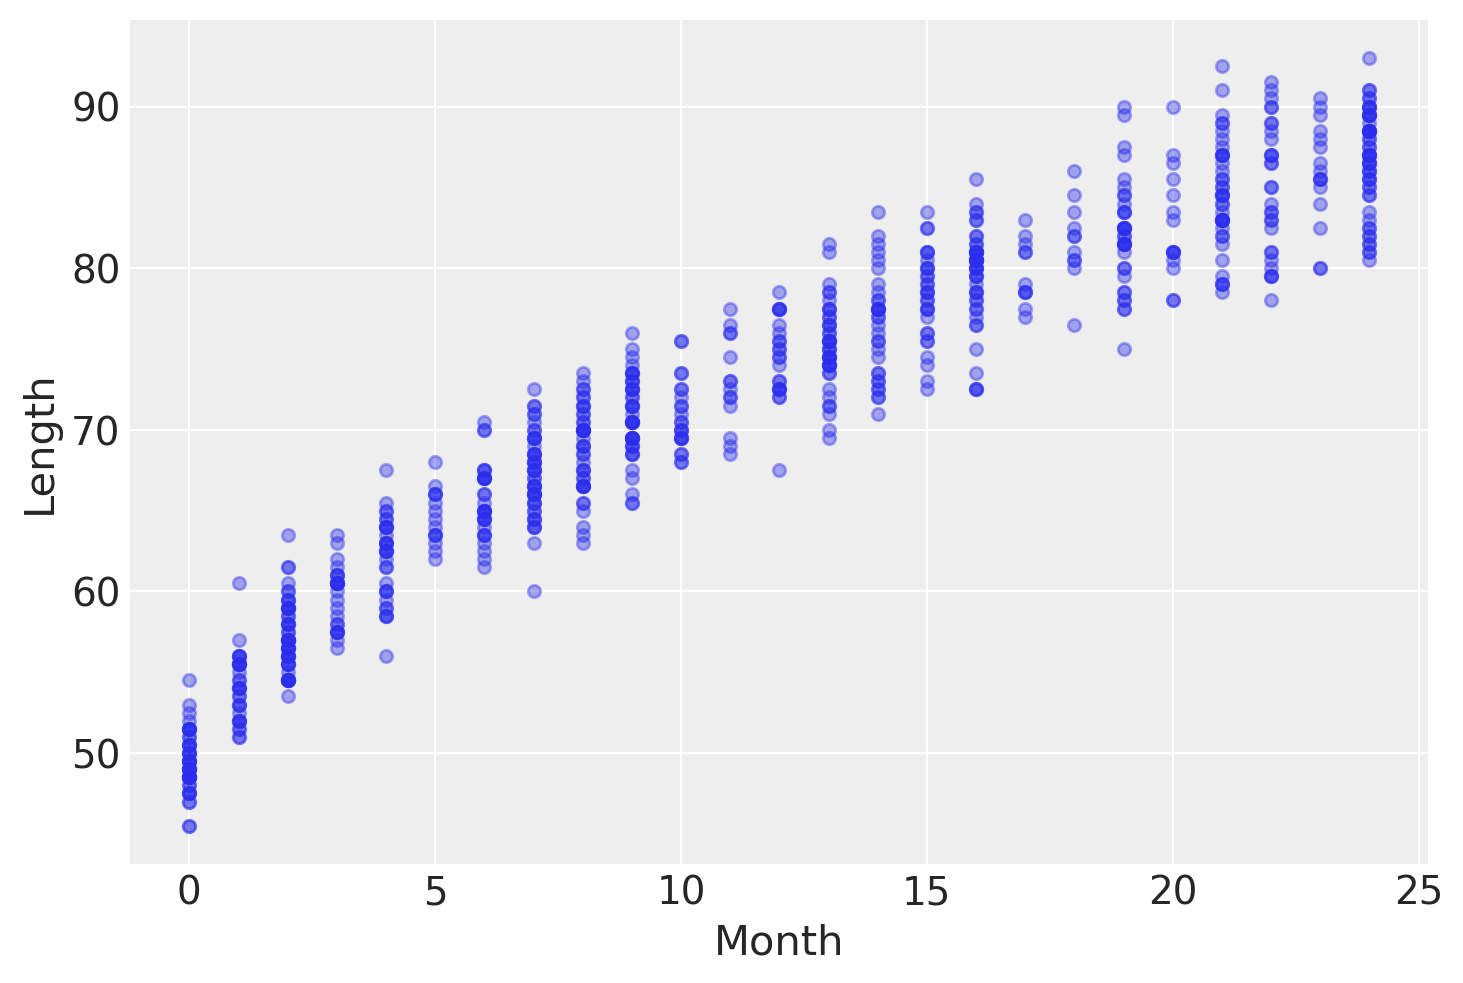

In [16]:
data = pd.read_csv(pm.get_data("babies.csv"))
data.plot.scatter("Month", "Length", alpha=0.4);

To model this data we are going to use this model:

In [17]:
with pm.Model() as model_babies:
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    month = pm.Data("month", data.Month.values.astype(float))

    μ = pm.Deterministic("μ", α + β * month ** 0.5)
    ε = pm.Deterministic("ε", γ + δ * month)

    length = pm.Normal("length", mu=μ, sigma=ε, observed=data.Length)

    trace_babies = pm.sample(tune=2000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [δ, γ, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 17 seconds.


The following figure shows the result of our model. The expected length, $\mu$, is represented with a blue curve, and two semi-transparent orange bands represent the 60% and 94% highest posterior density intervals of posterior predictive length measurements:

In [18]:
with model_babies:
    pp_length = pm.sample_posterior_predictive(trace_babies)["length"]

/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


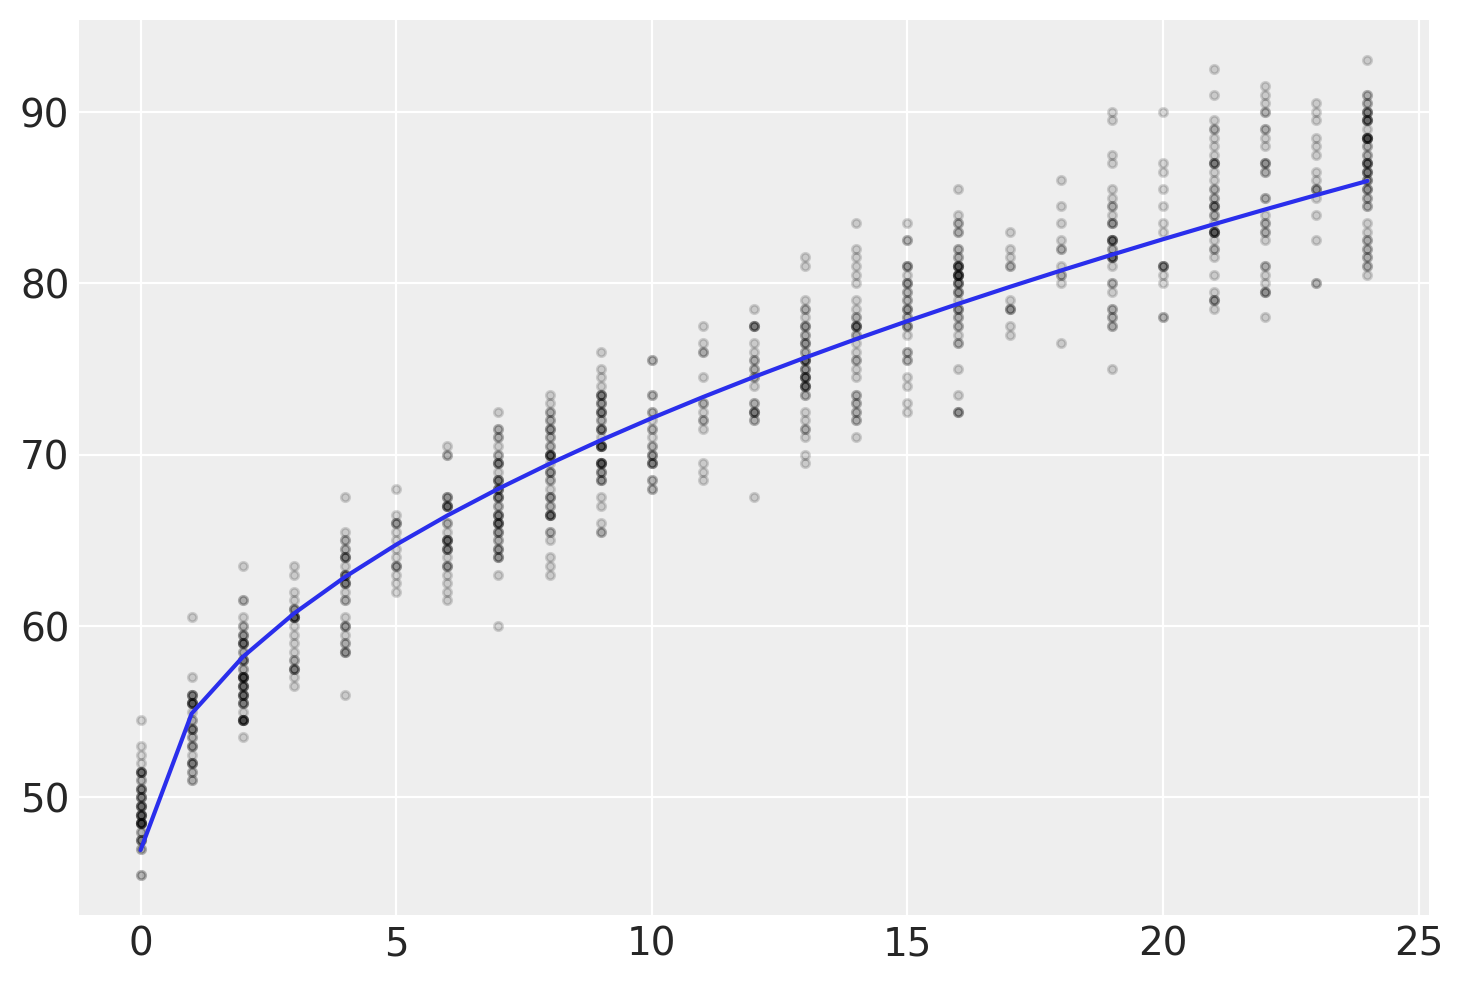

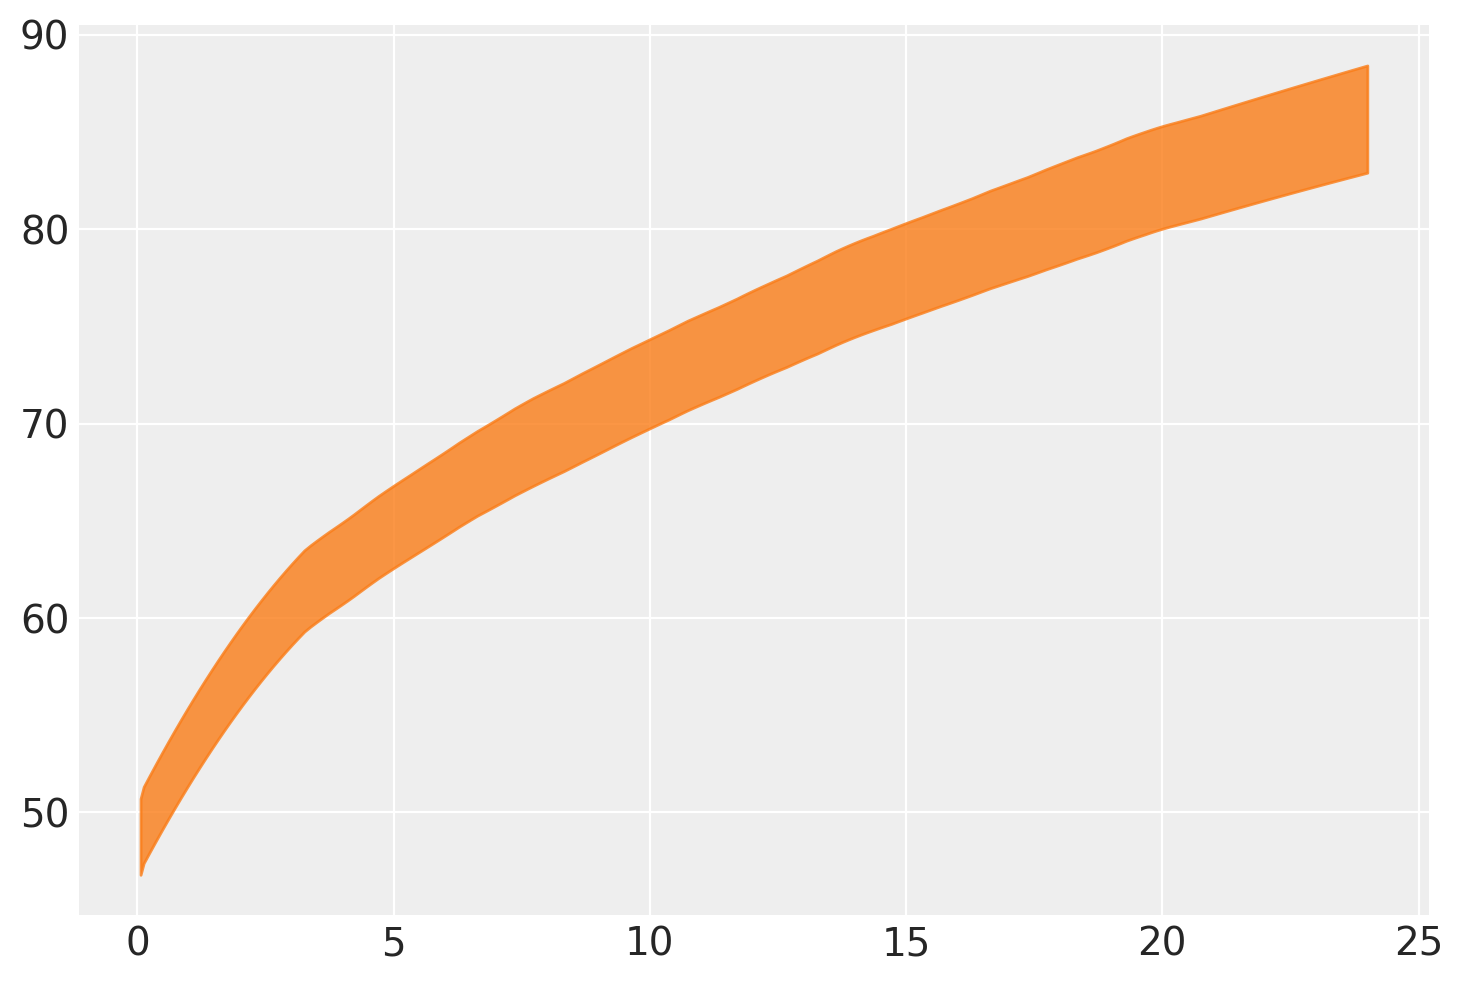

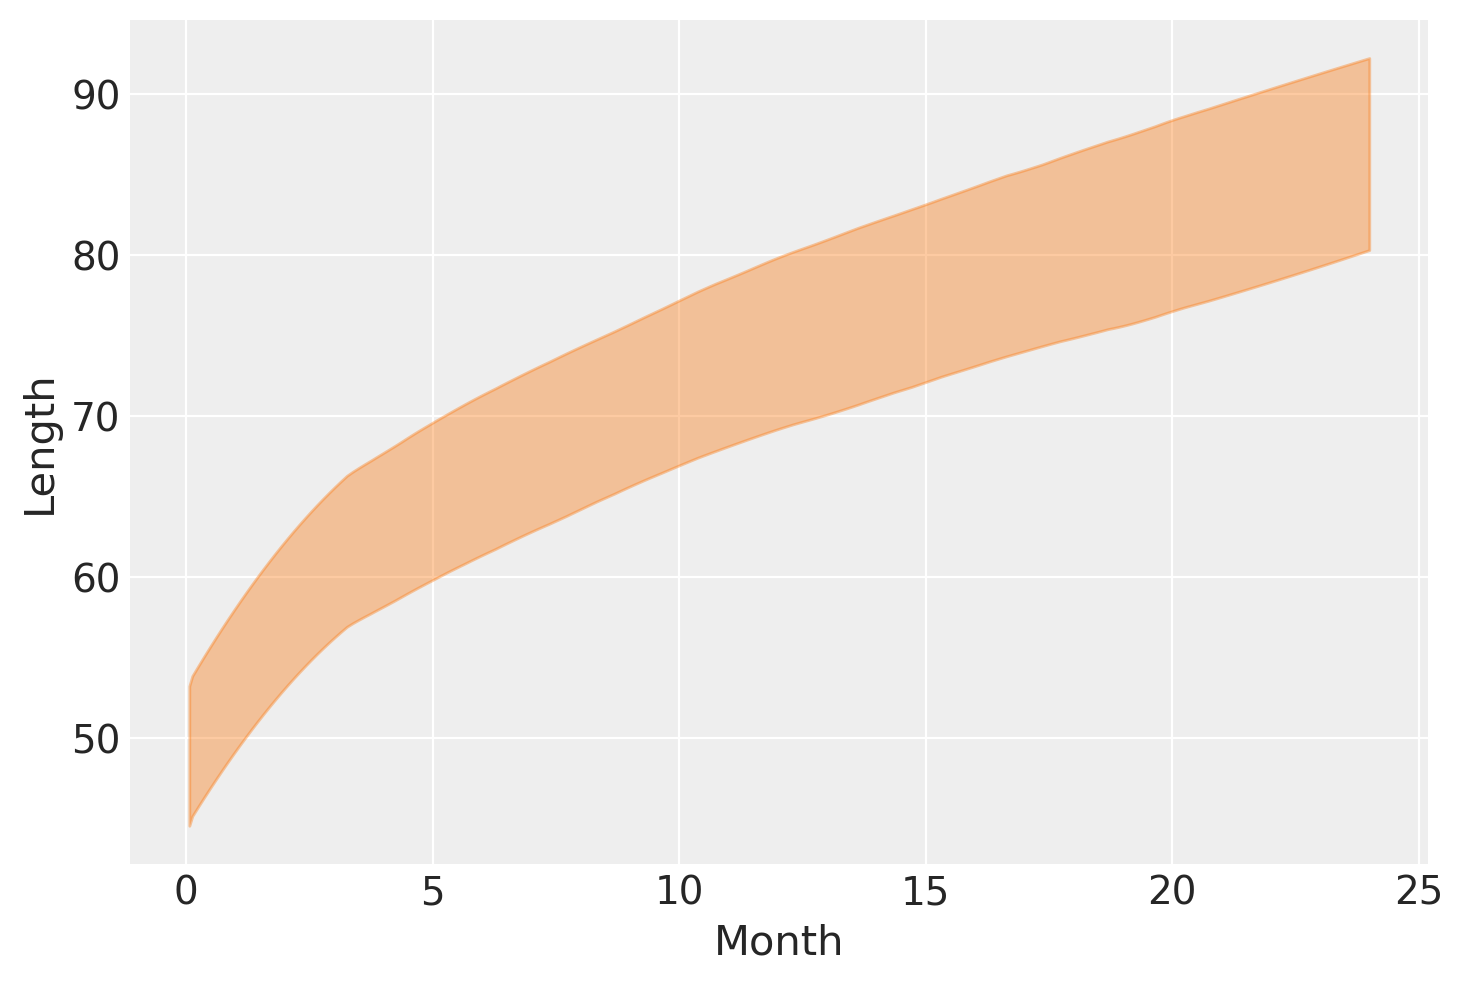

In [19]:
plt.plot(data.Month, data.Length, "k.", alpha=0.15)

plt.plot(data.Month, trace_babies["μ"].mean(0))
az.plot_hdi(data.Month, pp_length, hdi_prob=0.6, fill_kwargs={"alpha": 0.8})
az.plot_hdi(data.Month, pp_length, fill_kwargs={"alpha": 0.4})

plt.xlabel("Month")
plt.ylabel("Length");

At the moment of writing Osvaldo's daughter is two weeks ($\approx 0.5$ months) old, and thus he wonders how her length compares to the growth chart we have just created. One way to answer this question is to ask the model for the distribution of the variable length for babies of 0.5 months. Using PyMC3 we can ask this questions with the function `sample_posterior_predictive` , as this will return samples of _Length_ conditioned on the obseved data and the estimated distribution of parameters, that is including uncertainties. 

The only problem is that by default this function will return predictions for _Length_ for the observed values of _Month_, and $0.5$ months (the value Osvaldo cares about) has not been observed, -- all measures are reported for integer months. The easier way to get predictions for non-observed values of _Month_ is to pass new values to the `Data` container we defined above in our model. To do that, we need to use `pm.set_data` and then we just have to sample from the posterior predictve distribution:

In [20]:
with model_babies:
    pm.set_data({"month": [0.5]})
    length_ppc = pm.sample_posterior_predictive(trace_babies, 2000)

# need to get rid of second column because of this bug
# when predicting only one new value:
# https://github.com/pymc-devs/pymc3/issues/3640
length_ppc = length_ppc["length"][:, 0]

Now we can plot the expected distribution of lengths for 2-week old babies and compute additional quantities -- for example the percentile of a child given her length. Here, let's imagine that the child we're interested in has a length of 51.5:

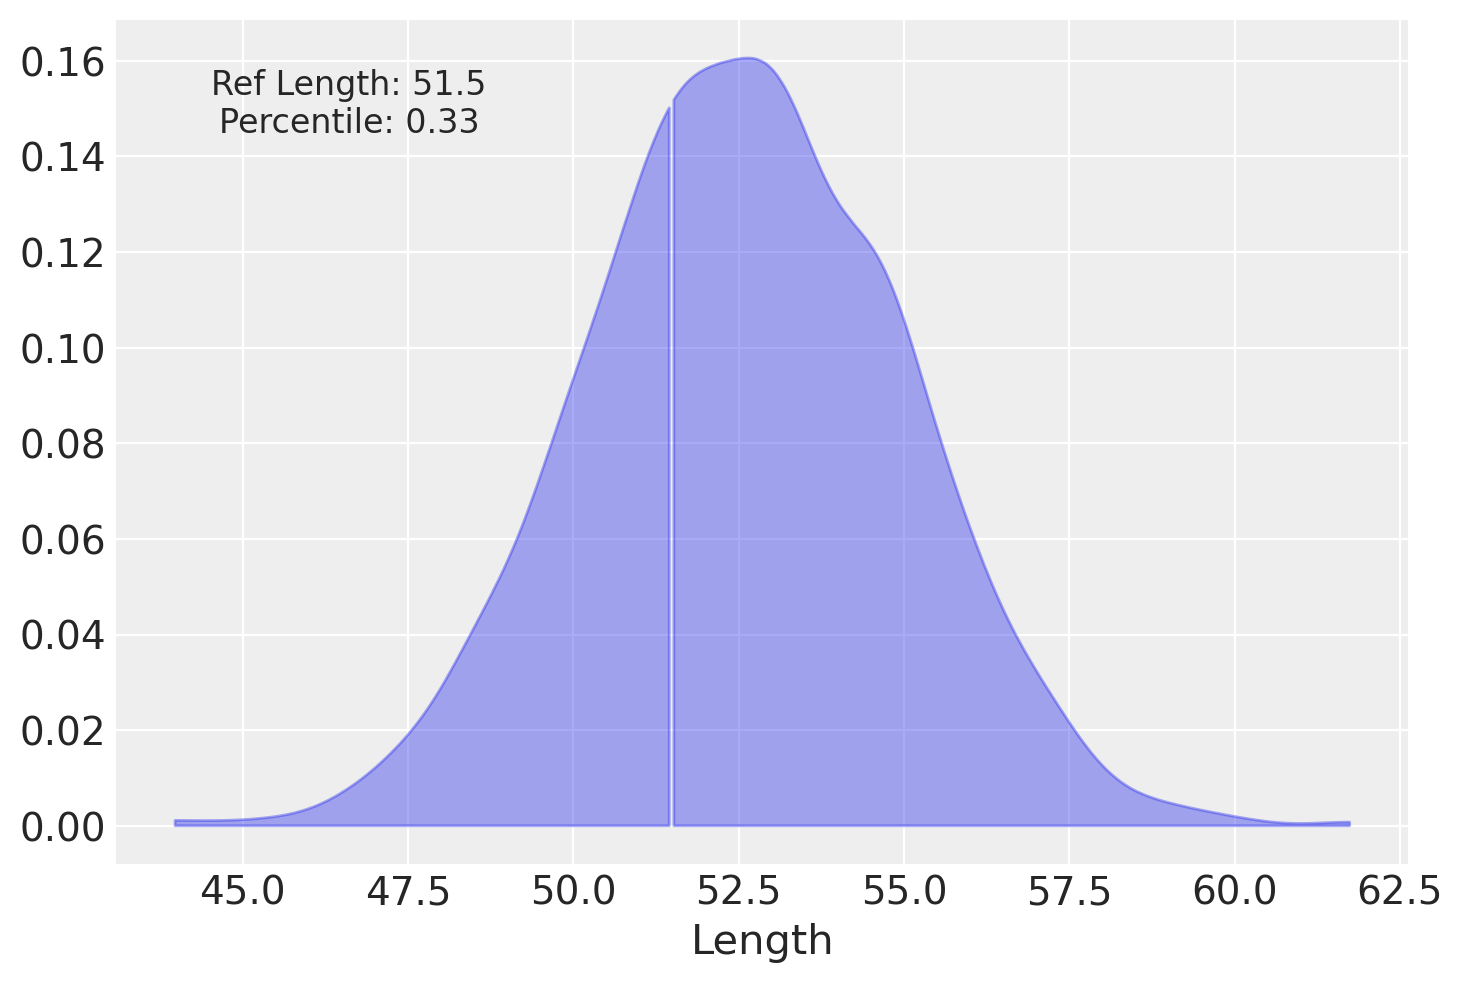

In [21]:
ref_length = 51.5
percentile = np.mean(length_ppc <= ref_length).round(2)

ax = az.plot_kde(length_ppc, quantiles=[percentile], fill_kwargs={"alpha": 0.4})
ax.text(
    0.18,
    0.9,
    f"Ref Length: {ref_length}\nPercentile: {percentile}",
    fontsize=12,
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
)
ax.set_xlabel("Length");

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 17 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy     : 1.19.2
arviz     : 0.10.0
pymc3     : 3.10.0
pandas    : 1.1.5
matplotlib: 3.3.3

Watermark: 2.1.0

